<a href="https://colab.research.google.com/github/fariba87/Voice-Conversion/blob/main/VoiceConversion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd /content/gdrive/MyDrive/Colab\ Notebooks

/content/gdrive/MyDrive


In [ ]:
!pip install praat-parselmouth 

psola , librosa , torch.audio , parselmouth


In [ ]:
import torch
import torchaudio
import parselmouth
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from parselmouth.praat import call


In [ ]:
audio_path = "src_audio_source.wav"
sound = parselmouth.Sound(audio_path)
from IPython.display import Audio
Audio(data=sound.values, rate=sound.sampling_frequency)

In [ ]:

manipulation = call(sound, "To Manipulation", 0.01, 25, 600)

In [ ]:
pitch_tier = call(manipulation, "Extract pitch tier")
call(pitch_tier, "Multiply frequencies", sound.xmin, sound.xmax, 2)
call([pitch_tier, manipulation], "Replace pitch tier")
sound_octave_up = call(manipulation, "Get resynthesis (overlap-add)")

In [ ]:
Audio(data=sound_octave_up.values, rate=sound_octave_up.sampling_frequency)


In [ ]:
import pitch
import numpy
import librosa
p = pitch.find_pitch('src_audio_source.wav')
'''
pitch correction
First, we would have to find out what the pitch actually is at a given point in time. We call this problem in DSP pitch tracking.
Second, we would need to choose our pitch adjustment strategy, i.e., how we would map the actual pitch to the desired pitch. Should we use a musical score? Various options are available here.
Third and final, we should adjust the pitch of the recording according to the calculated desired pitch. This step is called pitch shifting.
'''
'''
pitch tracking
PYIN is based on the YIN algorithm [2]. The YIN algorithm estimates the pitch from the time-domain signal through computing the autocorrelation function
 and then refining the result. PYIN extends this approach by applying a Hidden Markov Model to the outputs of the YIN algorithm.
'''

print('pitch =', p)
f0, voiced_flag, voiced_probabilities = librosa.pyin(audio,
                                                     frame_length=frame_length,
                                                     hop_length=hop_length,
                                                     sr=sr,
                                                     fmin=fmin,
                                                     fmax=fmax)
'''
Given a monophonic audio signal, the length of the analysis frames frame_length, the distance between the frames hop_length, the sampling rate sr, and the minimum and the maximum viable frequencies fmin and fmax, we obtain the estimated pitch for each frame f0, the information whether the given frame was voiced or not voiced_flag, and the probability of each frame being voiced voiced_probabilities.

We can use the information in the f0 vector to correct the pitch in the voiced frames as indicated by the voiced_flag. Alternatively, we can rely on the fact that f0 has not-a-number (NaN) values at the unvoiced frames.
'''

'''
Let’s again google for approaches to pitch shifting.

And again we’ll find the state of the art: the PSOLA algorithm [3].

PSOLA stands for Pitch-Synchronous Overlap-and-Add.

As a short recap:

Overlap-and-add (OLA) techniques allow us to change the time duration of a signal without changing its pitch (i.e., perform a time-scale modification, TSM) by dividing the signal into a series of overlapping frames and then reassembling those frames but with a different distance between the frames.
Resampling allows us to change the duration and the pitch of the signal together (see my tutorial on the variable speed replay effect which uses this approach).
A combination of an OLA-technique with resampling allows us to change the pitch of a signal without changing its duration. OLA is used to counteract the inherent time-scale modification outcome of the resampling part.
Is PSOLA readily available in some Python package?

Of course it is!

We can simply use the vocode function from the psola package.

Listing 2.


'''
import psola
pitch_shifted_signal = psola.vocode(audio,
                                    sample_rate=int(sr),
                                    target_pitch=corrected_f0,
                                    fmin=fmin,
                                    fmax=fmax)

'''
In this line of code, audio is the vocals recording, sample_rate is self-explanatory, target_pitch contains the values of the corrected pitch, and fmin and fmax are the minimum and the maximum target frequencies we’ll pitch-shift to.

The passed-in vector of the desired fundamental frequency values can be of any lenght; the psola library will simply space these values evenly throughout the signal duration. For example, if we pass in a signal with 4000 samples and target_pitch equal to [440, 880], the first 2000 samples will be pitch-shifted to 440 Hz and the remaining 2000 samples to 880 Hz.
'''


In [ ]:

# !/usr/bin/python3
from functools import partial
from pathlib import Path
import argparse
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
import scipy.signal as sig
import psola

SEMITONES_IN_OCTAVE = 12


def degrees_from(scale: str):
    """Return the pitch classes (degrees) that correspond to the given scale"""
    degrees = librosa.key_to_degrees(scale)
    # To properly perform pitch rounding to the nearest degree from the scale, we need to repeat
    # the first degree raised by an octave. Otherwise, pitches slightly lower than the base degree
    # would be incorrectly assigned.
    degrees = np.concatenate((degrees, [degrees[0] + SEMITONES_IN_OCTAVE]))
    return degrees


def closest_pitch(f0):
    """Round the given pitch values to the nearest MIDI note numbers"""
    midi_note = np.around(librosa.hz_to_midi(f0))
    # To preserve the nan values.
    nan_indices = np.isnan(f0)
    midi_note[nan_indices] = np.nan
    # Convert back to Hz.
    return librosa.midi_to_hz(midi_note)


def closest_pitch_from_scale(f0, scale):
    """Return the pitch closest to f0 that belongs to the given scale"""
    # Preserve nan.
    if np.isnan(f0):
        return np.nan
    degrees = degrees_from(scale)
    midi_note = librosa.hz_to_midi(f0)
    # Subtract the multiplicities of 12 so that we have the real-valued pitch class of the
    # input pitch.
    degree = midi_note % SEMITONES_IN_OCTAVE
    # Find the closest pitch class from the scale.
    degree_id = np.argmin(np.abs(degrees - degree))
    # Calculate the difference between the input pitch class and the desired pitch class.
    degree_difference = degree - degrees[degree_id]
    # Shift the input MIDI note number by the calculated difference.
    midi_note -= degree_difference
    # Convert to Hz.
    return librosa.midi_to_hz(midi_note)


def aclosest_pitch_from_scale(f0, scale):
    """Map each pitch in the f0 array to the closest pitch belonging to the given scale."""
    sanitized_pitch = np.zeros_like(f0)
    for i in np.arange(f0.shape[0]):
        sanitized_pitch[i] = closest_pitch_from_scale(f0[i], scale)
    # Perform median filtering to additionally smooth the corrected pitch.
    smoothed_sanitized_pitch = sig.medfilt(sanitized_pitch, kernel_size=11)
    # Remove the additional NaN values after median filtering.
    smoothed_sanitized_pitch[np.isnan(smoothed_sanitized_pitch)] = \
        sanitized_pitch[np.isnan(smoothed_sanitized_pitch)]
    return smoothed_sanitized_pitch


def autotune(audio, sr, correction_function, plot=False):
    # Set some basis parameters.
    frame_length = 2048
    hop_length = frame_length // 4
    fmin = librosa.note_to_hz('C2')
    fmax = librosa.note_to_hz('C7')

    # Pitch tracking using the PYIN algorithm.
    f0, voiced_flag, voiced_probabilities = librosa.pyin(audio,
                                                         frame_length=frame_length,
                                                         hop_length=hop_length,
                                                         sr=sr,
                                                         fmin=fmin,
                                                         fmax=fmax)

    # Apply the chosen adjustment strategy to the pitch.
    corrected_f0 = correction_function(f0)

    if plot:
        # Plot the spectrogram, overlaid with the original pitch trajectory and the adjusted
        # pitch trajectory.
        stft = librosa.stft(audio, n_fft=frame_length, hop_length=hop_length)
        time_points = librosa.times_like(stft, sr=sr, hop_length=hop_length)
        log_stft = librosa.amplitude_to_db(np.abs(stft), ref=np.max)
        fig, ax = plt.subplots()
        img = librosa.display.specshow(log_stft, x_axis='time', y_axis='log', ax=ax, sr=sr, hop_length=hop_length,
                                       fmin=fmin, fmax=fmax)
        fig.colorbar(img, ax=ax, format="%+2.f dB")
        ax.plot(time_points, f0, label='original pitch', color='cyan', linewidth=2)
        ax.plot(time_points, corrected_f0, label='corrected pitch', color='orange', linewidth=1)
        ax.legend(loc='upper right')
        plt.ylabel('Frequency [Hz]')
        plt.xlabel('Time [M:SS]')
        plt.savefig('pitch_correction.png', dpi=300, bbox_inches='tight')

    # Pitch-shifting using the PSOLA algorithm.
    return psola.vocode(audio, sample_rate=int(sr), target_pitch=corrected_f0, fmin=fmin, fmax=fmax)

filepath = Path('src_audio_source.wav')

# Load the audio file.
y, sr = librosa.load(str(filepath), sr=None, mono=False)
 # Only mono-files are handled. If stereo files are supplied, only the first channel is used.
if y.ndim > 1:
   y = y[0, :]

    # Pick the pitch adjustment strategy according to the arguments.
correction_function = closest_pitch #if #args.correction_method == 'closest' else \
        #partial(aclosest_pitch_from_scale, scale=args.scale)

    # Perform the auto-tuning.
pitch_corrected_y = autotune(y, sr, correction_function, False)

    # Write the corrected audio to an output file.
filepath = filepath.parent / (filepath.stem + '_pitch_corrected' + filepath.suffix)
sf.write(str(filepath), pitch_corrected_y, sr)


# def main():
#     # Parse the command line arguments.
#     ap = argparse.ArgumentParser()
#     ap.add_argument('vocals_file')
#     ap.add_argument('--plot', '-p', action='store_true', default=False,
#                     help='if set, will produce a plot of the results')
#     ap.add_argument('--correction-method', '-c', choices=['closest', 'scale'], default='closest')
#     ap.add_argument('--scale', '-s', type=str, help='see librosa.key_to_degrees;'
#                                                     ' used only for the \"scale\" correction'


In [ ]:
!pip install psola

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Fixing random state for reproducibility
np.random.seed(19680801)


# Create new Figure with black background
fig = plt.figure(figsize=(8, 8), facecolor='black')

# Add a subplot with no frame
ax = plt.subplot(111, frameon=False)

# Generate random data
data = np.random.uniform(0, 1, (64, 75))
X = np.linspace(-1, 1, data.shape[-1])
G = 1.5 * np.exp(-4 * X ** 2)

# Generate line plots
lines = []
for i in range(len(data)):
    # Small reduction of the X extents to get a cheap perspective effect
    xscale = 1 - i / 200.
    # Same for linewidth (thicker strokes on bottom)
    lw = 1.5 - i / 100.0
    line, = ax.plot(xscale * X, i + G * data[i], color="w", lw=lw)
    lines.append(line)

# Set y limit (or first line is cropped because of thickness)
ax.set_ylim(-1, 70)

# No ticks
ax.set_xticks([])
ax.set_yticks([])

# 2 part titles to get different font weights
ax.text(0.5, 1.0, "MATPLOTLIB ", transform=ax.transAxes,
        ha="right", va="bottom", color="w",
        family="sans-serif", fontweight="light", fontsize=16)
ax.text(0.5, 1.0, "UNCHAINED", transform=ax.transAxes,
        ha="left", va="bottom", color="w",
        family="sans-serif", fontweight="bold", fontsize=16)


def update(*args):
    # Shift all data to the right
    data[:, 1:] = data[:, :-1]

    # Fill-in new values
    data[:, 0] = np.random.uniform(0, 1, len(data))

    # Update data
    for i in range(len(data)):
        lines[i].set_ydata(i + G * data[i])

    # Return modified artists
    return lines

# Construct the animation, using the update function as the animation director.
anim = animation.FuncAnimation(fig, update, interval=10)
plt.show()

In [ ]:
import torch
import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T

print(torch.__version__)
print(torchaudio.__version__)
import parselmouth
from IPython.display import Audio
SPEECH_WAVEFORM, SAMPLE_RATE = torchaudio.load("src_audio_source.wav")
print(SPEECH_WAVEFORM, SAMPLE_RATE)

1.13.1+cu116
0.13.1+cu116
tensor([[ 0.0000e+00, -1.1921e-07,  0.0000e+00,  ..., -9.9657e-03,
         -9.9629e-03, -1.0389e-02],
        [ 0.0000e+00, -1.1921e-07,  0.0000e+00,  ..., -9.9657e-03,
         -9.9629e-03, -1.0389e-02]]) 44100


In [ ]:
#SAMPLE_SPEECH = download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav")
SAMPLE_SPEECH = "src_audio_source.wav"
#torchaudio.load
def plot_waveform(waveform, sr, title="Waveform"):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sr

    figure, axes = plt.subplots(num_channels, 1)
    axes.plot(time_axis, waveform[0], linewidth=1)
    axes.grid(True)
    figure.suptitle(title)
    plt.show(block=False)


def plot_spectrogram(specgram, title=None, ylabel="freq_bin"):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto")
    fig.colorbar(im, ax=axs)
    plt.show(block=False)


def plot_fbank(fbank, title=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Filter bank")
    axs.imshow(fbank, aspect="auto")
    axs.set_ylabel("frequency bin")
    axs.set_xlabel("mel bin")
    plt.show(block=False)
SPEECH_WAVEFORM, SAMPLE_RATE = torchaudio.load(SAMPLE_SPEECH)

#plot_waveform(SPEECH_WAVEFORM, SAMPLE_RATE, title="Original waveform")
Audio(SPEECH_WAVEFORM.numpy(), rate=SAMPLE_RATE)


In [ ]:
 SAMPLE_RATE

44100

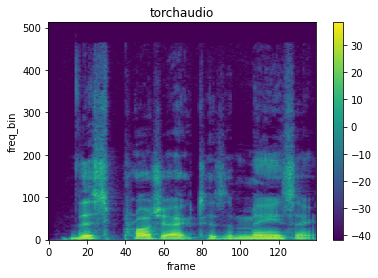

In [ ]:

n_fft = 1024
win_length = None
hop_length = 512

# Define transform
spectrogram = T.Spectrogram(
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
)

# Perform transform
spec = spectrogram(SPEECH_WAVEFORM)
plot_spectrogram(spec[0], title="torchaudio")

torch.random.manual_seed(0)

n_fft = 1024
win_length = None
hop_length = 512

spec = T.Spectrogram(
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
)(SPEECH_WAVEFORM)

griffin_lim = T.GriffinLim(
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
)

reconstructed_waveform = griffin_lim(spec)
# plot_waveform(reconstructed_waveform, SAMPLE_RATE, title="Reconstructed")
Audio(reconstructed_waveform, rate=SAMPLE_RATE)


In [ ]:
import torch
import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T
from IPython.display import Audio
import librosa
import matplotlib.pyplot as plt
import librosa
melspec_librosa = librosa.feature.melspectrogram(
    y=SPEECH_WAVEFORM.numpy()[0],
    sr=sample_rate,
    n_fft=n_fft,
    hop_length=hop_length,
    win_length=win_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
    n_mels=n_mels,
    norm="slaney",
    htk=True,
)
plot_spectrogram(melspec_librosa, title="MelSpectrogram - librosa", ylabel="mel freq")
from torchaudio.utils import download_asset

torch.random.manual_seed(0)







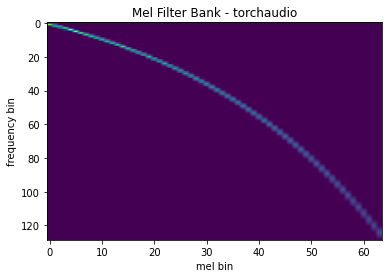

In [ ]:
n_fft = 256
n_mels = 64
sample_rate = 6000
mel_filters = F.melscale_fbanks(
    int(n_fft // 2 + 1),
    n_mels=n_mels,
    f_min=0.0,
    f_max=sample_rate / 2.0,
    sample_rate=sample_rate,
    norm="slaney",
)

plot_fbank(mel_filters, "Mel Filter Bank - torchaudio")